In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pybamm
import pickle
import os112878
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [2]:
# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

temp_list = list(discharge_data.keys())

In [3]:
# Here I am not going to work with changing the initial conditions the gradient descent
# so this is taking the ICs for granted 
Ms = 32
n4 = 4
F = 9.649e4
S8_initial = 2.6730
ns8 = 8
S4_initial = 0.0128
ns4 = 4
cth = ((3 * n4 * F * S8_initial / (ns8 * Ms)) + (n4 * F * S4_initial / (ns4 * Ms))) / 3600

# define the initial values in grams of various species
S8_initial_g = 2.6730
S4_initial_g = 0.0128
S2_initial_g = 4.3321e-6
S1_initial_g = 1.6321e-6
Sp_initial_g = 2.7e-06

# the total active material mass
m_s = S8_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

In [4]:
def discharge_function(inputs):
    
    fitted_params_dict, temp = inputs
    
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.MarinescuEtAl2016_ks_temp()
    
    # non-fitted parameters
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Ambient Temperature [K]": temp,
        #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
        #"Lower voltage cut-off [V]": 2.0,
        "Initial Condition for Terminal Voltage [V]": discharge_initial_data[0],
        }
    )
    # fitted parameters (which are initial species values and initial voltage)
    params.update(fitted_params_dict)
    
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [3,4,5,6]:
        print("trying number of time steps %f" %10**j)
        print("parameters are {}".format(fitted_params_dict))
        try:
            # simulate
            sim.solve(np.linspace(0, time_in_seconds,10**j))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries

            data = {'time' : t, 
                    'capacity' : Ah, 
                    'voltage' : V, 
                    'S8' : S8, 
                    'S4' : S4, 
                    'S2' : S2, 
                    'S1' : S1, 
                    'Sp' : Sp
                   } 
            return data
            
            break
        except:
            pass

In [5]:
def charge_function(inputs):
    
    fitted_params_dict, temp = inputs
    
    current = -0.0211 # .1C charge
    model = pybamm.lithium_sulfur.MarinescuEtAl2016_ks_temp()
    
    # non-fitted parameters
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Ambient Temperature [K]": temp,
        #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
        #"Lower voltage cut-off [V]": 2.0,
        "Initial Condition for Terminal Voltage [V]": discharge_initial_data[0],
        }
    )
    # fitted parameters (which are initial species values and initial voltage)
    params.update(fitted_params_dict)
    
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [3,4,5,6]:
        print("trying number of time steps %f" %10**j)
        print("parameters are {}".format(fitted_params_dict))
        try:
            # simulate
            sim.solve(np.linspace(0, time_in_seconds,10**j))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries

            data = {'time' : t, 
                    'capacity' : Ah, 
                    'voltage' : V, 
                    'S8' : S8, 
                    'S4' : S4, 
                    'S2' : S2, 
                    'S1' : S1, 
                    'Sp' : Sp
                   } 
            return data
            
            break
        except:
            pass

In [6]:
all_params = [
    {
        "Initial Condition for Terminal Voltage [V]": discharge_initial_data[0],
        "Initial Condition for S8 ion [g]": discharge_initial_data[1] ,
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3],
        "Initial Condition for S ion [g]": discharge_initial_data[4],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5],
        "Precipitation rate [s-1]": 100,
        "Lower voltage cut-off [V]": 2.15,
    }                      
]

discharges_100 = []
temp_list = [30,40]
for temp_c in temp_list:
    temp_k = temp_c + 272.15
    inputs = all_params[-1], temp_k
    discharge_dict = discharge_function(inputs)
    discharges_100.append(discharge_dict)
  

Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 100, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 100, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 100000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 100, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 17976.6 and h = 2.06685e-17, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

Starting temperature 312.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 100, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

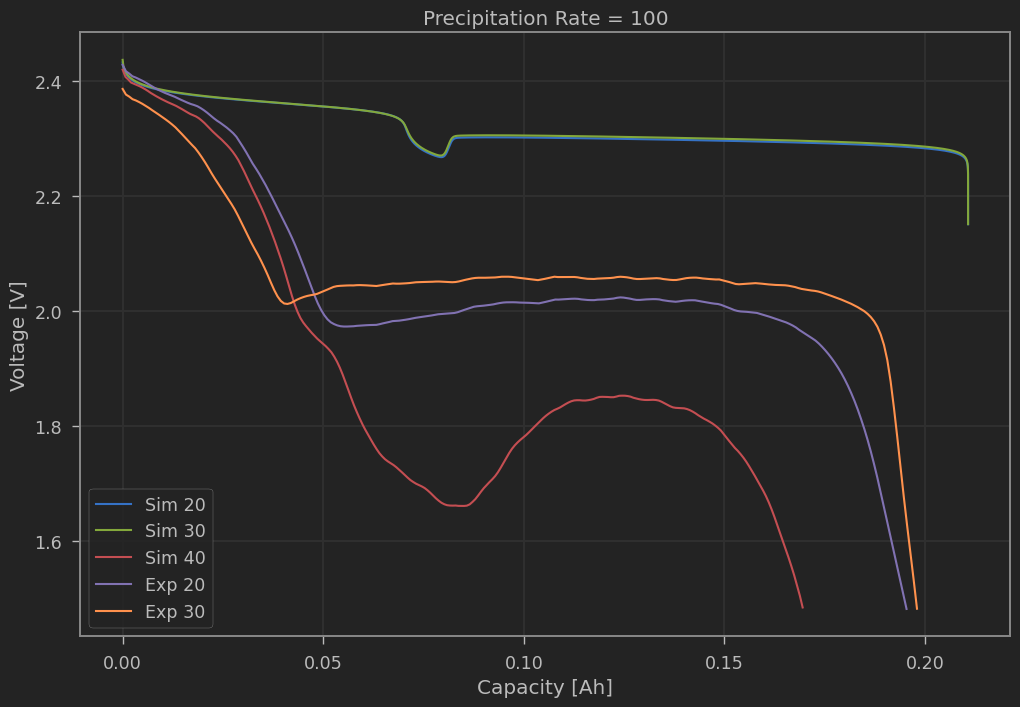

In [7]:
for discharge_dict in discharges_100:
    plt.plot(discharge_dict['capacity'], discharge_dict['voltage'])

plt.plot(discharge_data['20']['capacity'],discharge_data['20']['internal voltage'])
plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])
plt.plot(discharge_data['40']['capacity'],discharge_data['40']['internal voltage'])
plt.legend(['Sim 20','Sim 30','Sim 40','Exp 20','Exp 30','Exp 40'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Precipitation Rate = '+str(all_params[0]["Precipitation rate [s-1]"]))
plt.grid(True)  

In [8]:
all_params = [
    {
        "Initial Condition for Terminal Voltage [V]": discharge_initial_data[0],
        "Initial Condition for S8 ion [g]": discharge_initial_data[1] ,
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3],
        "Initial Condition for S ion [g]": discharge_initial_data[4],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5],
        "Precipitation rate [s-1]": 1000,
        "Lower voltage cut-off [V]": 2.15,
    }                      
]

discharges_1000 = []
temp_list = [20,30,40]
for temp_c in temp_list:
    temp_k = temp_c + 272.15
    inputs = all_params[-1], temp_k
    discharge_dict = discharge_function(inputs)
    discharges_1000.append(discharge_dict)
  

Starting temperature 292.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 1000, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 1000, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 100000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 1000, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 17976.6 and h = 6.61391e-16, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 1000, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 312.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 1000, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

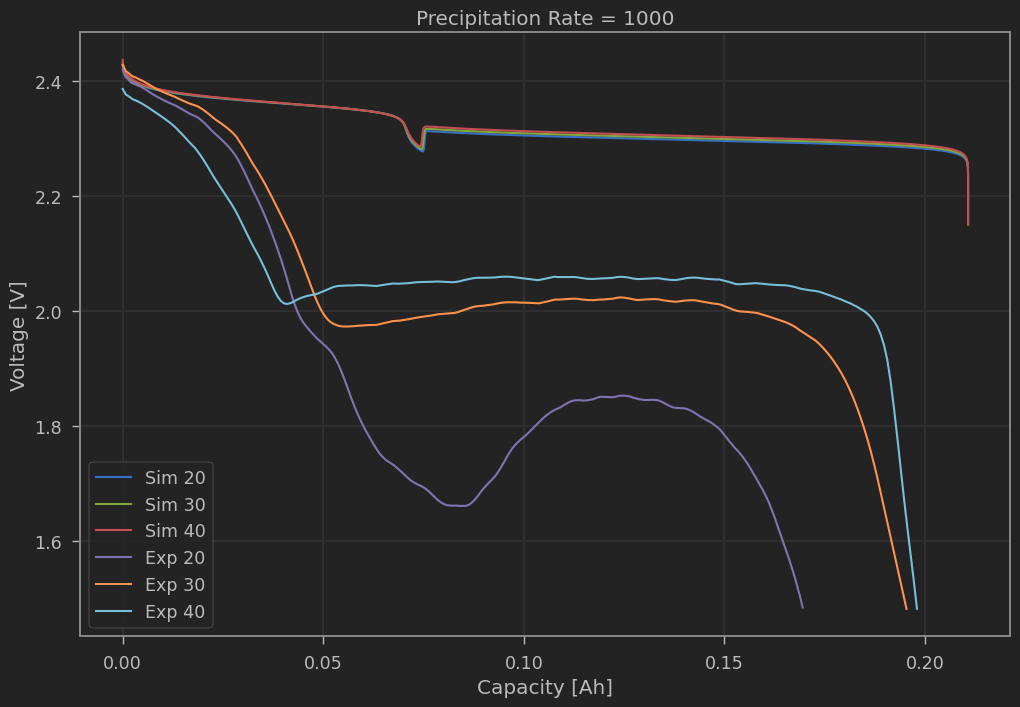

In [9]:
for discharge_dict in discharges_1000:
    plt.plot(discharge_dict['capacity'], discharge_dict['voltage'])

plt.plot(discharge_data['20']['capacity'],discharge_data['20']['internal voltage'])
plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])
plt.plot(discharge_data['40']['capacity'],discharge_data['40']['internal voltage'])
plt.legend(['Sim 20','Sim 30','Sim 40','Exp 20','Exp 30','Exp 40'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Precipitation Rate = '+str(all_params[0]["Precipitation rate [s-1]"]))
plt.grid(True)  

In [10]:
all_params = [
    {
        "Initial Condition for Terminal Voltage [V]": discharge_initial_data[0],
        "Initial Condition for S8 ion [g]": discharge_initial_data[1] ,
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3],
        "Initial Condition for S ion [g]": discharge_initial_data[4],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5],
        "Precipitation rate [s-1]": 10,
        "Lower voltage cut-off [V]": 2.15,
    }                      
]

discharges_10 = []
temp_list = [20,30,40]
for temp_c in temp_list:
    temp_k = temp_c + 272.15
    inputs = all_params[-1], temp_k
    discharge_dict = discharge_function(inputs)
    discharges_10.append(discharge_dict)
  

Starting temperature 292.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 10, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 10, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 100000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 10, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 10, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 312.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 10, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 10, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 100000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'Precipitation rate [s-1]': 10, 'Lower voltage cut-off [V]': 2.15}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

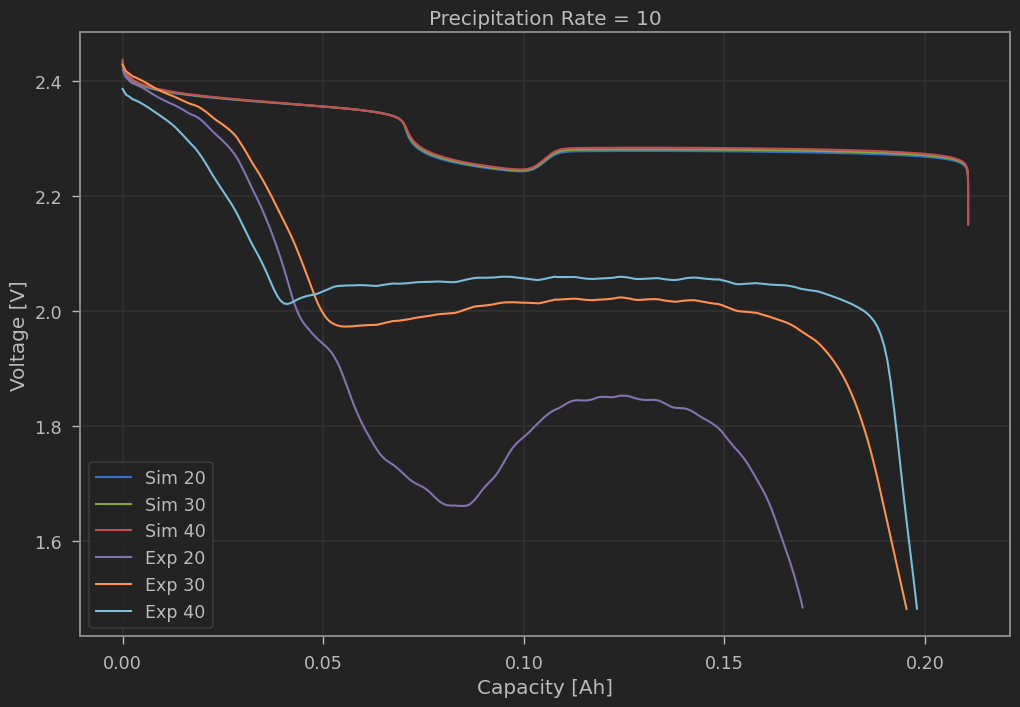

In [11]:
for discharge_dict in discharges_10:
    plt.plot(discharge_dict['capacity'], discharge_dict['voltage'])

plt.plot(discharge_data['20']['capacity'],discharge_data['20']['internal voltage'])
plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])
plt.plot(discharge_data['40']['capacity'],discharge_data['40']['internal voltage'])
plt.legend(['Sim 20','Sim 30','Sim 40','Exp 20','Exp 30','Exp 40'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Precipitation Rate = '+str(all_params[0]["Precipitation rate [s-1]"]))
plt.grid(True)  

In [12]:
all_params = [
    {
        "Initial Condition for Terminal Voltage [V]": discharge_initial_data[0],
        "Initial Condition for S8 ion [g]": discharge_initial_data[1] ,
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3],
        "Initial Condition for S ion [g]": discharge_initial_data[4],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5],
        "S saturation mass [g]": 0.001,
        "Lower voltage cut-off [V]": 2.1,
    }                      
]

discharges_001 = []
temp_list = [20,30,40]
for temp_c in temp_list:
    temp_k = temp_c + 272.15
    inputs = all_params[-1], temp_k
    discharge_dict = discharge_function(inputs)
    discharges_001.append(discharge_dict)

Starting temperature 292.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.001, 'Lower voltage cut-off [V]': 2.1}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.001, 'Lower voltage cut-off [V]': 2.1}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 100000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.001, 'Lower voltage cut-off [V]': 2.1}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 302.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.001, 'Lower voltage cut-off [V]': 2.1}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.001, 'Lower voltage cut-off [V]': 2.1}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 100000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.001, 'Lower voltage cut-off [V]': 2.1}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

Starting temperature 312.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.001, 'Lower voltage cut-off [V]': 2.1}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 17976.6 and h = 1.65512e-14, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

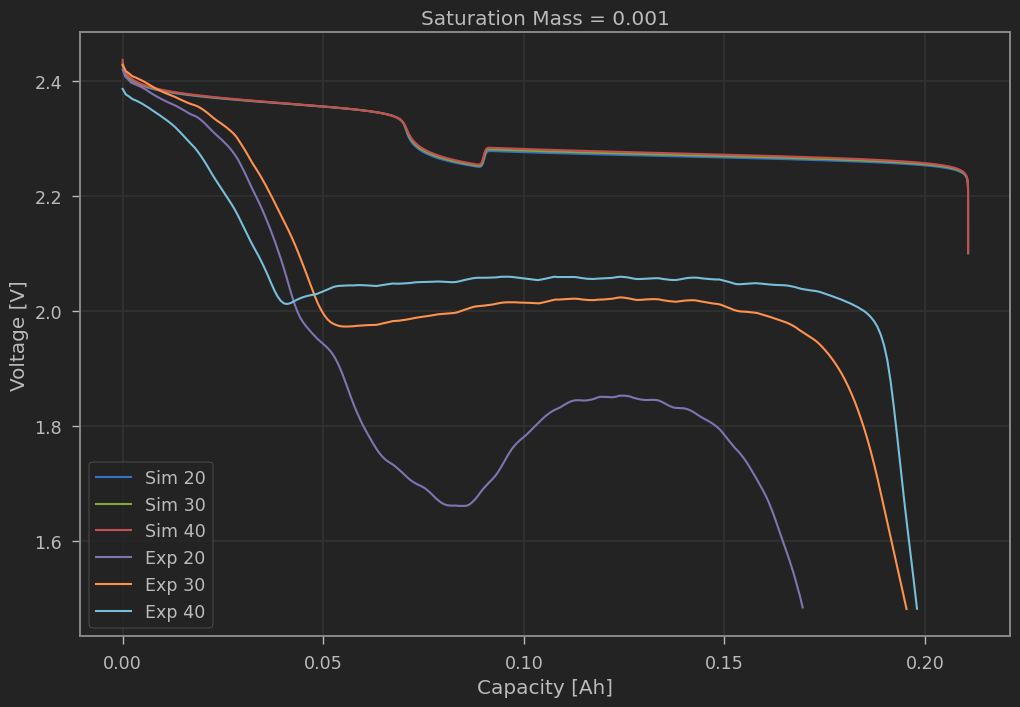

In [13]:
for discharge_dict in discharges_001:
    plt.plot(discharge_dict['capacity'], discharge_dict['voltage'])

plt.plot(discharge_data['20']['capacity'],discharge_data['20']['internal voltage'])
plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])
plt.plot(discharge_data['40']['capacity'],discharge_data['40']['internal voltage'])
plt.legend(['Sim 20','Sim 30','Sim 40','Exp 20','Exp 30','Exp 40'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Saturation Mass = '+str(all_params[0]["S saturation mass [g]"]))
plt.grid(True)  

In [14]:
all_params = [
    {
        "Initial Condition for Terminal Voltage [V]": discharge_initial_data[0],
        "Initial Condition for S8 ion [g]": discharge_initial_data[1] ,
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3],
        "Initial Condition for S ion [g]": discharge_initial_data[4],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5],
        "S saturation mass [g]": 0.01,
        "Precipitation rate [s-1]": 5000,
        "Lower voltage cut-off [V]": 2.0,
    }                      
]

discharges_01 = []
temp_list = [20,30,40]
for temp_c in temp_list:
    temp_k = temp_c + 272.15
    inputs = all_params[-1], temp_k
    discharge_dict = discharge_function(inputs)
    discharges_01.append(discharge_dict) 

Starting temperature 292.150000
trying number of time steps 1000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.01, 'Precipitation rate [s-1]': 5000, 'Lower voltage cut-off [V]': 2.0}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 17976.6 and h = 1.69484e-11, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.01, 'Precipitation rate [s-1]': 5000, 'Lower voltage cut-off [V]': 2.0}


res failed: KeyboardInterrupt
The residual function failed unrecoverably. 


trying number of time steps 100000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.01, 'Precipitation rate [s-1]': 5000, 'Lower voltage cut-off [V]': 2.0}
trying number of time steps 1000000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.01, 'Precipitation rate [s-1]': 5000, 'Lowe

res failed: KeyboardInterrupt
At t = 955.699, the residual function failed unrecoverably.
res failed: KeyboardInterrupt
At t = 1805.35, the residual function failed unrecoverably.


trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.01, 'Precipitation rate [s-1]': 5000, 'Lower voltage cut-off [V]': 2.0}
trying number of time steps 100000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.01, 'Precipitation rate [s-1]': 5000, 'Lower 

res failed: KeyboardInterrupt
At t = 948.881, the residual function failed unrecoverably.
res failed: KeyboardInterrupt
At t = 1714.96, the residual function failed unrecoverably.
res failed: KeyboardInterrupt
At t = 2193.86, the residual function failed unrecoverably.


trying number of time steps 10000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.01, 'Precipitation rate [s-1]': 5000, 'Lower voltage cut-off [V]': 2.0}


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

trying number of time steps 100000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.01, 'Precipitation rate [s-1]': 5000, 'Lower voltage cut-off [V]': 2.0}
trying number of time steps 1000000.000000
parameters are {'Initial Condition for Terminal Voltage [V]': 2.4, 'Initial Condition for S8 ion [g]': 0.1671988053302967, 'Initial Condition for S4 ion [g]': 0.0008006527153863815, 'Initial Condition for S2 ion [g]': 2.7097715846291745e-07, 'Initial Condition for S ion [g]': 1.020894763111026e-07, 'Initial Condition for Precipitated Sulfur [g]': 1.6888768215181486e-07, 'S saturation mass [g]': 0.01, 'Precipitation rate [s-1]': 5000, 'Lowe

res failed: KeyboardInterrupt
At t = 3.62261, the residual function failed unrecoverably.


In [15]:
for discharge_dict in discharges_01:
    plt.plot(discharge_dict['capacity'], discharge_dict['voltage'])

plt.plot(discharge_data['20']['capacity'],discharge_data['20']['internal voltage'])
plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])
plt.plot(discharge_data['40']['capacity'],discharge_data['40']['internal voltage'])
plt.legend(['Sim 20','Sim 30','Sim 40','Exp 20','Exp 30','Exp 40'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Saturation Mass = '+str(all_params[0]["S saturation mass [g]"]))
plt.grid(True)  

TypeError: 'NoneType' object is not subscriptable

In [ ]:
temp_loc = 0
plt.plot(discharges_0001[temp_loc]['capacity'], discharges_0001[temp_loc]['voltage'])
plt.plot(discharges_001[temp_loc]['capacity'], discharges_001[temp_loc]['voltage'])
plt.plot(discharges_01[temp_loc]['capacity'], discharges_01[temp_loc]['voltage'])
plt.legend(['0.0001','0.001','0.01'])
plt.title('20 C')
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

In [ ]:
temp_loc = 1
plt.plot(discharges_0001[temp_loc]['capacity'], discharges_0001[temp_loc]['voltage'])
plt.plot(discharges_001[temp_loc]['capacity'], discharges_001[temp_loc]['voltage'])
plt.plot(discharges_01[temp_loc]['capacity'], discharges_01[temp_loc]['voltage'])
plt.legend(['0.0001','0.001','0.01'])
plt.title('30 C')
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

In [ ]:
temp_loc = 2
plt.plot(discharges_0001[temp_loc]['capacity'], discharges_0001[temp_loc]['voltage'])
plt.plot(discharges_001[temp_loc]['capacity'], discharges_001[temp_loc]['voltage'])
plt.plot(discharges_01[temp_loc]['capacity'], discharges_01[temp_loc]['voltage'])
plt.legend(['0.0001','0.001','0.01'])
plt.title('40 C')
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

In [ ]:
notify